# Binary Operators Neural Network

This is a series of ANN examples that are trained on simple binary math operations.
Like simple unary operations, simple binary operations are easily modeled in an ANN.
More complex operations, like `d` - the distance from the 2d point to the origin,
are well modeled in 2 layer networks.
Division is the most difficult to fit.

## Preliminaries

Import time, random, tensorflow and plotting libraries.
Set the random number seed, tf log level and enable inline plotting.

In [1]:
import math
from random import random, seed
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import matmul, array, set_printoptions, fabs, argmin, argmax, sum, linspace
from time import time

seed(9001)
tf.logging.set_verbosity(tf.logging.ERROR)
set_printoptions(suppress=True, precision=3)
%matplotlib inline

## `fr` function

`fr` formats floating point numbers into a standard format.

In [2]:
def fr(n):
    try:
        return ', '.join([fr(x) for x in n])
    except TypeError:
        return '{0:+.3f}'.format(n)

## `generator` function

`generator` returns a tuple where the `op` on the first two vectors results in the third vector.
It also returns the lambda expression.

If `op` is `''`, an the array of operations is return.

In [20]:
def generator(op='', n=1, show=5, epsilon=1e-6):

    operations = {
        'a': (lambda a, b: a),
        'b': (lambda a, b: b),
        'A': (lambda a, b: -a),
        'B': (lambda a, b: -b),
        '+': (lambda a, b: a + b),
        '-': (lambda a, b: a - b),
        '*': (lambda a, b: a * b),
        '/': (lambda a, b: a / b),
        'd2': (lambda a, b: a*a + b*b),
        'd': (lambda a, b: math.sqrt(a*a + b*b))
    };
    
    if op == '':
        return [k for k in operations];
    
    if op in operations:
        bop = operations[op];
    else:
        raise NotImplementedError('Unknown Operator', op) 
    
    # generate a random number in (-1, 1)
    def rnd(nonzero=False):
        res = -1.0
        while res == -1.0 or (nonzero and res <= epsilon and res >= -epsilon):
            res = 2.0 * random() - 1.0
        return res

    # generate sample data
    av = []
    bv = []
    cv = []
    for i in range(n):
        a = rnd()
        b = rnd(nonzero=(op=='/'))
        c = bop(a, b)
        av.append(a)
        bv.append(b)
        cv.append(c)
        if i < show:
            print(fr([a, b, c]))

    return av, bv, cv, bop

## Sample output of `generator`

In [18]:
for op in generator():
    print('Operation: ' + op)
    generator(op=op, n=1)

Operation: a
-0.118, -0.485, -0.118
Operation: b
+0.107, -0.857, -0.857
Operation: A
-0.579, -0.055, +0.579
Operation: B
-0.005, +0.396, -0.396
Operation: +
-0.918, +0.018, -0.900
Operation: -
-0.205, -0.980, +0.775
Operation: *
-0.967, +0.519, -0.502
Operation: /
-0.720, -0.020, +35.715
Operation: d2
+0.098, +0.738, +0.554
Operation: d
+0.118, +0.049, +0.127


## `train` the ANN

`train` runs the entire ANN optimization process.
Training and test data are simulated and
the DNN regressor is configured.
Then for each epoch: the training data are prepared for fitting;
the test data are evaluated;
predictions are made and training stops if they are close enough.

Graphical results are displayed showing the improvement in the loss function
and examples of the error results.

Each ANN layer is displayed as grayscale images of weights and biases.
hiddenlayer_0 will always have 2 rows
and the final logits layer will always have 1 column.

In [14]:
def train(op, hidden_units, epochs, samples, test_samples, steps,
          opt=tf.train.AdamOptimizer,
          epsilon=0.0, vrange=1.0, display=True):
    stime = time()
    losses = []
    layers = len(hidden_units)

    training = generator(op=op, n=samples, show=0, epsilon=epsilon)
    testing = generator(op=op, n=test_samples, show=0, epsilon=epsilon)
    
    estimator = tf.contrib.learn.DNNRegressor(
        feature_columns=[tf.contrib.layers.real_valued_column(k) for k in ['a', 'b']],
        optimizer=opt,
        hidden_units=hidden_units)

    def prepx(ds):
        return {
            'a': tf.constant(ds[0]),
            'b': tf.constant(ds[1])
        }

    def prepy(ds):
        return tf.constant(ds[2])

    def prep(ds):
        return (prepx(ds), prepy(ds))
    
    for epoch in range(epochs):
        estimator.fit(input_fn=lambda: prep(training), steps=steps)
        res = estimator.evaluate(input_fn=lambda: prep(testing), steps=1)
        loss = res["loss"]
        losses.append(loss)
        
        prediction = list(estimator.predict(input_fn=lambda: prepx(testing)))
        expected = testing[2]
        errors = fabs(array(prediction) - array(expected))
        mine = argmin(errors)
        maxe = argmax(errors)
        ave = sum(errors) / test_samples
        if errors[maxe] < epsilon:
            break;

    etime = (time()-stime)/3600
    
    def aplot(axs, w, title):
        lmtx = len(w)
        lmty = len(w[0])
        intx = int(pow(10, math.floor(math.log10(lmtx)-.1)))
        inty = int(pow(10, math.floor(math.log10(lmty)-.1)))
        plt.xticks(linspace(0, lmtx, intx))
        plt.yticks(linspace(lmty, 0, inty))
        axs.set_title(title)
        im = axs.imshow(w, cmap="gray", vmin=-vrange, vmax=vrange)
        return im

    def wgtplot(axs, w, title):
        return aplot(axs, w, title + ' weights')

    def biasplot(axs, b, title):
        return aplot(axs, [b], title + ' biases')
    
    if display == True:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
        axs[0].plot(losses)
        axs[0].set_title(op + ' Losses: ' + fr(loss))
        axs[0].set_xlabel('Iteration')
        axs[1].bar([i for i in range(test_samples)], sorted(errors, reverse=True))
        axs[1].set_title('Average Error:' + fr(ave))
        axs[1].set_xlabel('Test Sample')
        
        wgts = ['hiddenlayer_'+str(i) for i in range(layers)]
        wgts.append('logits')
        for i in range(len(wgts)):
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
            
            w = estimator.get_variable_value('dnn/'+wgts[i]+'/weights')
            wgtplot(axs[0], w, wgts[i])
            
            b = estimator.get_variable_value('dnn/'+wgts[i]+'/biases')
            im = biasplot(axs[1], b, wgts[i])
            fig.colorbar(im)
        plt.show()
        plt.close('all')
        
        print('Sample Calculation for: ' + op)
        testa = testing[0]
        testb = testing[1]
        testc = testing[2]
        testop = testing[3]
        lo = array([testa[mine], testb[mine]])
        hi = array([testa[maxe], testb[maxe]])
        print('Inputs (lo, hi): {0:40s}{1:s}'.format(fr(lo), fr(hi)))
        print('Expected Output: {0:40s}{1:s}'.format(fr(testc[mine]), fr(testc[maxe])))
        for i in range(len(wgts)):
            w = estimator.get_variable_value('dnn/'+wgts[i]+'/weights')
            b = estimator.get_variable_value('dnn/'+wgts[i]+'/biases')
            print('')
            print('Layer ' + wgts[i])
            print(w)
            print(b)
            lo = lo.dot(w)
            hi = hi.dot(w)
            print('  Post Weights: {0:40s}{1:s}'.format(fr(lo), fr(hi)))
            lo = lo + b
            hi = hi + b
            print('  Post  Biases: {0:40s}{1:s}'.format(fr(lo), fr(hi)))
            if (wgts[i] != 'logits'):
                lo = array([max(lo[i], 0) for i in range(len(lo))])
                hi = array([max(hi[i], 0) for i in range(len(hi))])
                print('  Post    ReLu: {0:40s}{1:s}'.format(fr(lo), fr(hi)))

        print('')
        print('Elapse Time: {:.4f} hours'.format(etime))

    return {'testing': testing,
            'training': training,
            'ann': estimator,
            'losses': losses,
            'elapsed': etime
           }

##  `train` on simple problems

Consider the case where ReLu does not effect the calculation.
For any linear combination of any $x$, $y$ inputs:

$$
 \left[
  \left[ {\begin{array}{cc}
   x & y
  \end{array} } \right]
  \left[ {\begin{array}{cc}
   a & b \\
   c & d \\
  \end{array} } \right]
  +
  \left[ {\begin{array}{cc}
   e & f
  \end{array} } \right]
 \right]
 \left[ {\begin{array}{c}
   g \\
   h \\
 \end{array} } \right]
 +
 \left[ {\begin{array}{c}
   i \\
 \end{array} } \right] = mx + ny
$$

$$
  \left[ {\begin{array}{cc}
   ax+cy+e & bx+dy+f \\
  \end{array} } \right]
 \left[ {\begin{array}{c}
   g \\
   h \\
 \end{array} } \right]
 +
 \left[ {\begin{array}{c}
   i \\
 \end{array} } \right] = mx + ny
$$

$$
 \begin{array}{cccc}
  gax+gcy+ge & +\ hbx+hdy+hf & +\ i & = mx + ny \\
  (ga+hb)x & +\ (gc+hd)y & +\ (ge+hf+i) & = mx + ny \\
   ga + hb = m & gc+hd = n & ge+hf+i = 0 & \\
   ga = m-hb & gc = n-hd & i = -ge-hf & \\
  \end{array}
$$


## Difference operation

Here the difference between two numbers is modelled a few times with good fits but with very different solutions.

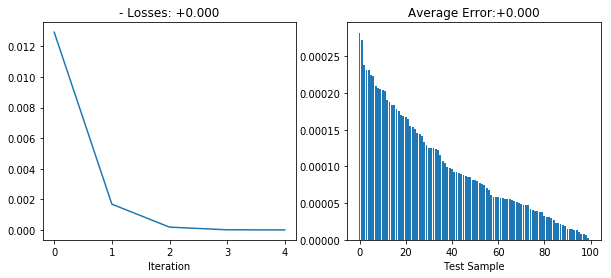

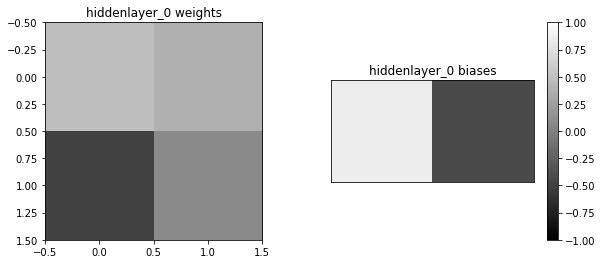

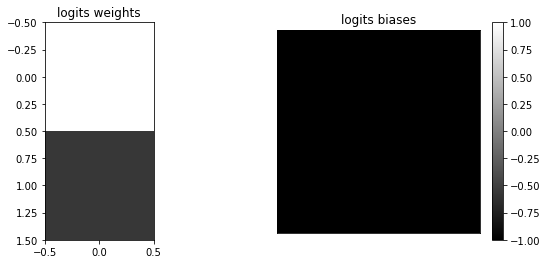

Sample Calculation for: -
Inputs (lo, hi): -0.249, +0.278                          -0.990, -0.895
Expected Output: -0.527                                  -0.095

Layer hiddenlayer_0
[[ 0.486  0.382]
 [-0.486  0.079]]
[ 0.855 -0.429]
  Post Weights: -0.256, -0.073                          -0.046, -0.449
  Post  Biases: +0.599, -0.502                          +0.808, -0.877
  Post    ReLu: +0.599, +0.000                          +0.808, +0.000

Layer logits
[[ 2.059]
 [-0.567]]
[-1.76]
  Post Weights: +1.233                                  +1.665
  Post  Biases: -0.527                                  -0.095

Elapse Time: 0.0070 hours


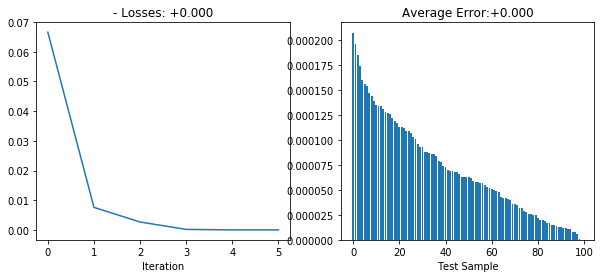

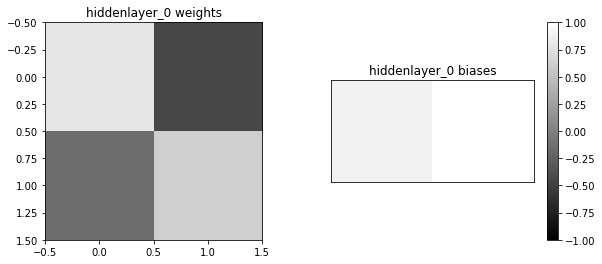

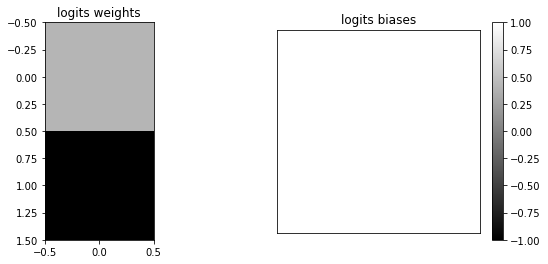

Sample Calculation for: -
Inputs (lo, hi): +0.695, +0.574                          -0.891, +0.941
Expected Output: +0.121                                  -1.832

Layer hiddenlayer_0
[[ 0.797 -0.439]
 [-0.147  0.619]]
[0.886 1.02 ]
  Post Weights: +0.470, +0.051                          -0.849, +0.974
  Post  Biases: +1.356, +1.071                          +0.037, +1.993
  Post    ReLu: +1.356, +1.071                          +0.037, +1.993

Layer logits
[[ 0.421]
 [-1.514]]
[1.171]
  Post Weights: -1.050                                  -3.003
  Post  Biases: +0.121                                  -1.832

Elapse Time: 0.0078 hours


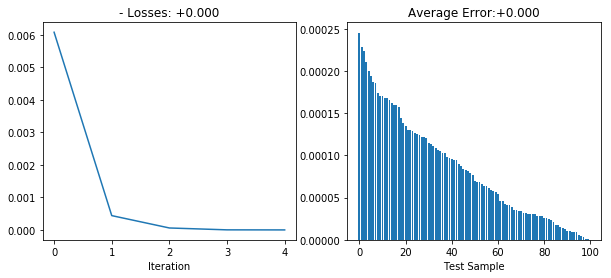

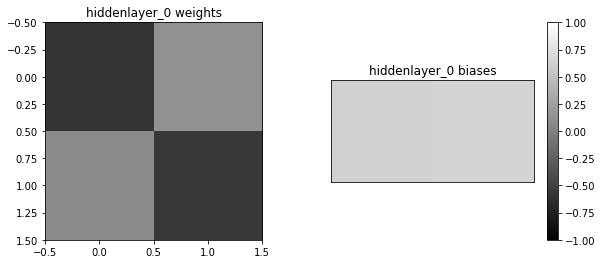

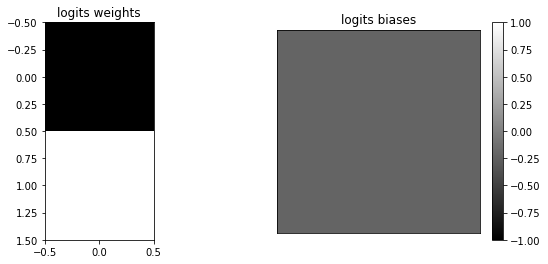

Sample Calculation for: -
Inputs (lo, hi): -0.010, -0.180                          -0.978, +0.931
Expected Output: +0.170                                  -1.909

Layer hiddenlayer_0
[[-0.581  0.14 ]
 [ 0.09  -0.547]]
[0.634 0.66 ]
  Post Weights: -0.011, +0.097                          +0.652, -0.646
  Post  Biases: +0.624, +0.757                          +1.287, +0.014
  Post    ReLu: +0.624, +0.757                          +1.287, +0.014

Layer logits
[[-1.335]
 [ 1.608]]
[-0.215]
  Post Weights: +0.385                                  -1.695
  Post  Biases: +0.170                                  -1.910

Elapse Time: 0.0066 hours


In [6]:
for _ in range(3):
    subop = train('-', [2], 100, 900, 100, 1000, epsilon=0.0005)

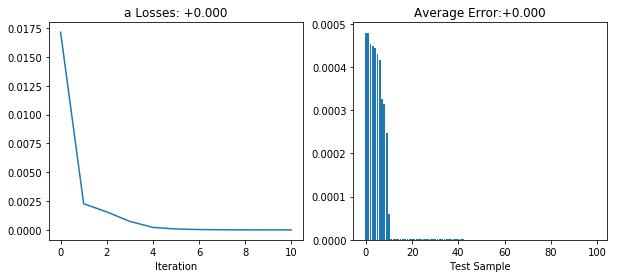

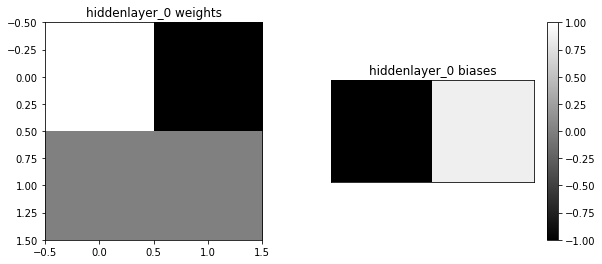

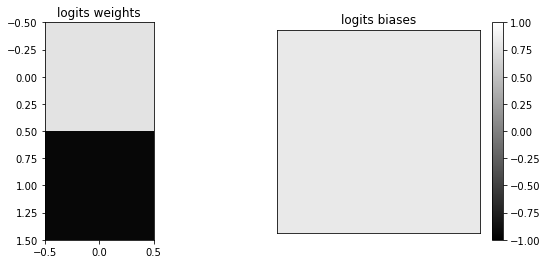

Sample Calculation for: a
Inputs (lo, hi): -0.834, -0.703                          +0.974, -0.142
Expected Output: -0.834                                  +0.974

Layer hiddenlayer_0
[[ 1.259 -1.06 ]
 [ 0.    -0.   ]]
[-1.038  0.874]
  Post Weights: -1.050, +0.883                          +1.226, -1.032
  Post  Biases: -2.088, +1.758                          +0.188, -0.157
  Post    ReLu: +0.000, +1.758                          +0.188, +0.000

Layer logits
[[ 0.788]
 [-0.944]]
[0.825]
  Post Weights: -1.659                                  +0.148
  Post  Biases: -0.834                                  +0.973

Elapse Time: 0.0123 hours


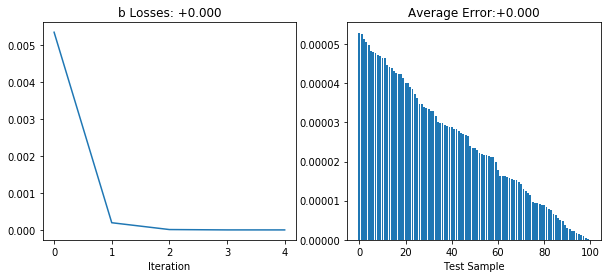

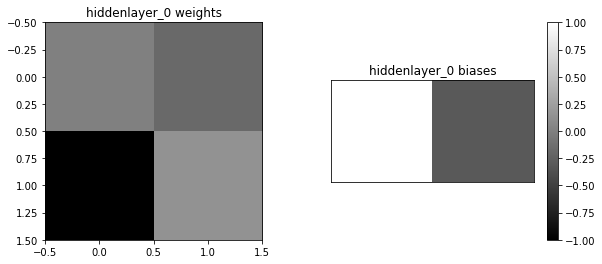

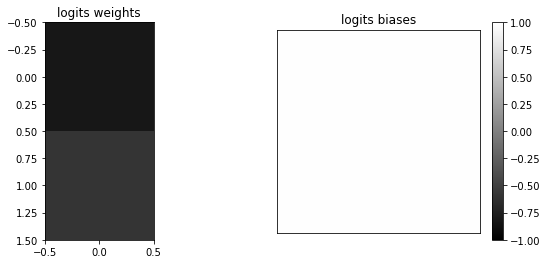

Sample Calculation for: b
Inputs (lo, hi): -0.761, -0.941                          -0.057, +0.982
Expected Output: -0.941                                  +0.982

Layer hiddenlayer_0
[[ 0.    -0.167]
 [-1.226  0.142]]
[ 1.21  -0.301]
  Post Weights: +1.153, -0.006                          -1.204, +0.149
  Post  Biases: +2.363, -0.308                          +0.006, -0.152
  Post    ReLu: +2.363, +0.000                          +0.006, +0.000

Layer logits
[[-0.815]
 [-0.586]]
[0.987]
  Post Weights: -1.927                                  -0.005
  Post  Biases: -0.941                                  +0.982

Elapse Time: 0.0056 hours


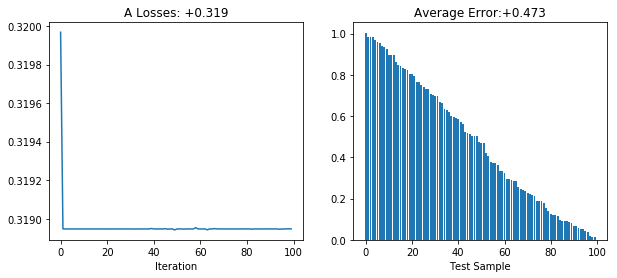

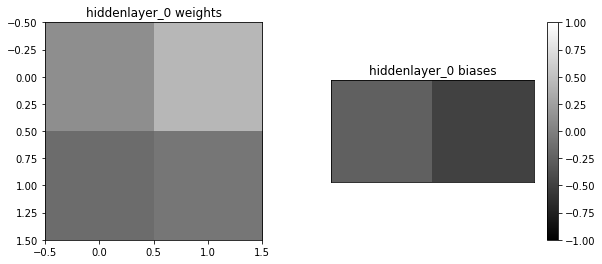

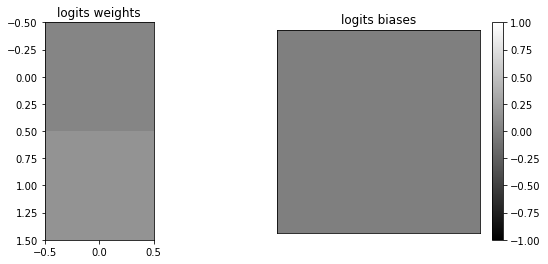

Sample Calculation for: A
Inputs (lo, hi): -0.009, +0.892                          -1.000, -0.356
Expected Output: +0.009                                  +1.000

Layer hiddenlayer_0
[[ 0.113  0.432]
 [-0.151 -0.075]]
[-0.245 -0.484]
  Post Weights: -0.136, -0.071                          -0.060, -0.405
  Post  Biases: -0.380, -0.554                          -0.304, -0.889
  Post    ReLu: +0.000, +0.000                          +0.000, +0.000

Layer logits
[[0.044]
 [0.157]]
[-0.004]
  Post Weights: +0.000                                  +0.000
  Post  Biases: -0.004                                  -0.004

Elapse Time: 0.1163 hours


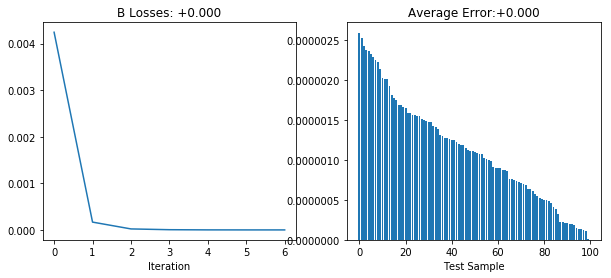

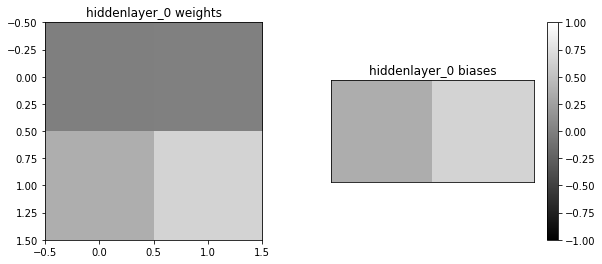

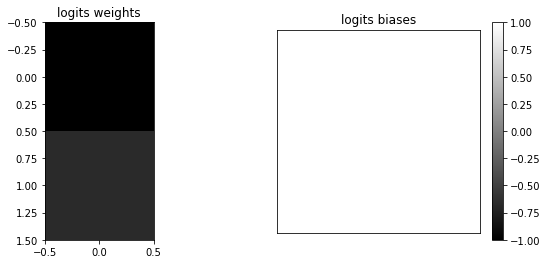

Sample Calculation for: B
Inputs (lo, hi): +0.133, +0.247                          -0.271, -0.996
Expected Output: -0.247                                  +0.996

Layer hiddenlayer_0
[[-0.     0.001]
 [ 0.361  0.655]]
[0.359 0.653]
  Post Weights: +0.089, +0.162                          -0.359, -0.652
  Post  Biases: +0.448, +0.815                          +0.000, +0.001
  Post    ReLu: +0.448, +0.815                          +0.000, +0.001

Layer logits
[[-1.565]
 [-0.666]]
[0.996]
  Post Weights: -1.244                                  -0.001
  Post  Biases: -0.247                                  +0.996

Elapse Time: 0.0080 hours


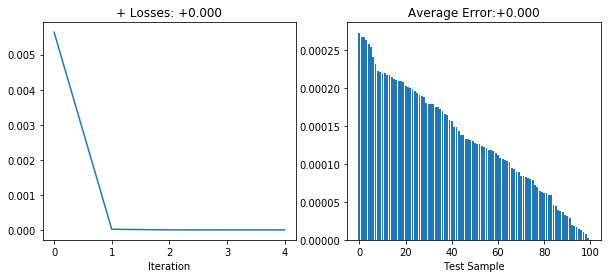

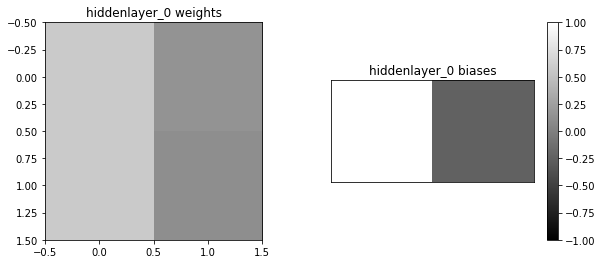

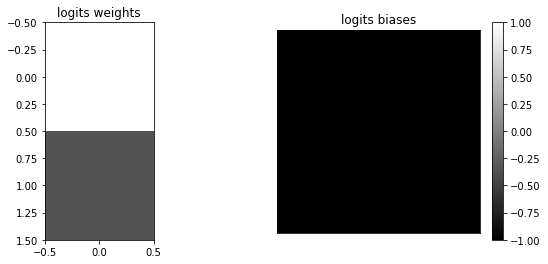

Sample Calculation for: +
Inputs (lo, hi): +0.848, +0.725                          -0.634, -0.794
Expected Output: +1.573                                  -1.429

Layer hiddenlayer_0
[[0.579 0.157]
 [0.579 0.11 ]]
[ 1.052 -0.241]
  Post Weights: +0.911, +0.213                          -0.827, -0.187
  Post  Biases: +1.963, -0.029                          +0.225, -0.428
  Post    ReLu: +1.963, +0.000                          +0.225, +0.000

Layer logits
[[ 1.727]
 [-0.349]]
[-1.818]
  Post Weights: +3.390                                  +0.389
  Post  Biases: +1.573                                  -1.429

Elapse Time: 0.0057 hours


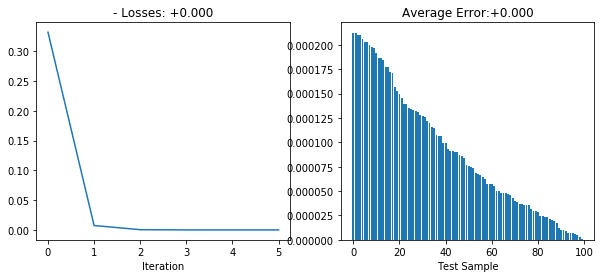

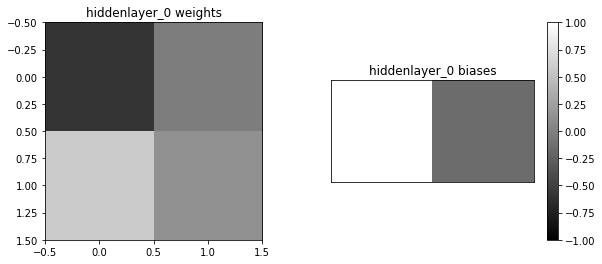

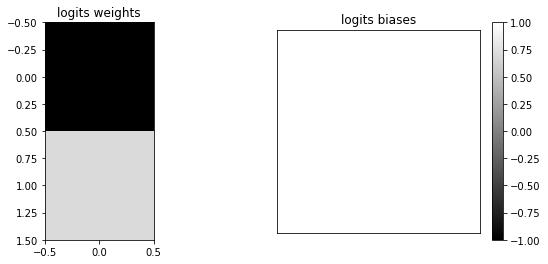

Sample Calculation for: -
Inputs (lo, hi): -0.498, +0.403                          +0.532, -0.919
Expected Output: -0.901                                  +1.451

Layer hiddenlayer_0
[[-0.59  -0.017]
 [ 0.59   0.137]]
[ 1.111 -0.153]
  Post Weights: +0.532, +0.063                          -0.857, -0.135
  Post  Biases: +1.643, -0.090                          +0.254, -0.288
  Post    ReLu: +1.643, +0.000                          +0.254, +0.000

Layer logits
[[-1.694]
 [ 0.704]]
[1.882]
  Post Weights: -2.783                                  -0.431
  Post  Biases: -0.901                                  +1.451

Elapse Time: 0.0069 hours


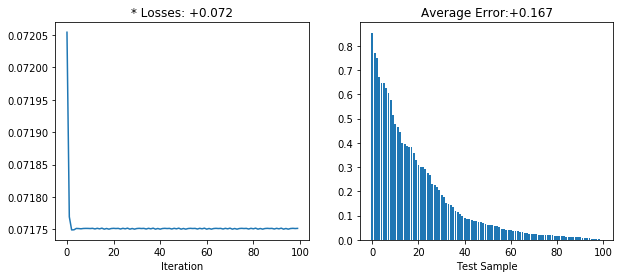

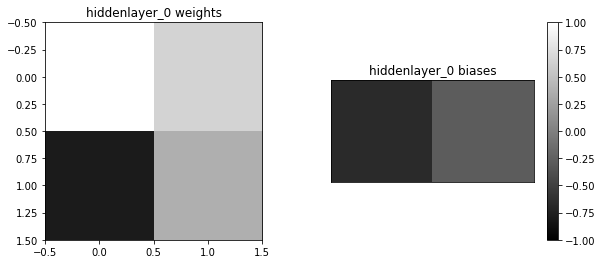

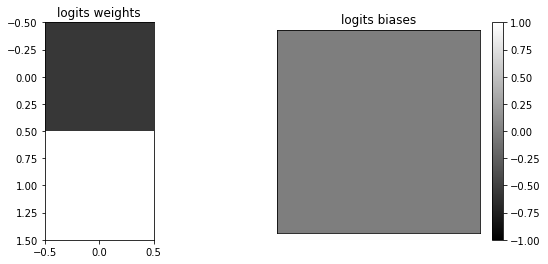

Sample Calculation for: *
Inputs (lo, hi): -0.316, +0.043                          -0.955, +0.907
Expected Output: -0.014                                  -0.867

Layer hiddenlayer_0
[[ 1.441  0.652]
 [-0.781  0.373]]
[-0.664 -0.276]
  Post Weights: -0.489, -0.190                          -2.085, -0.285
  Post  Biases: -1.154, -0.467                          -2.750, -0.561
  Post    ReLu: +0.000, +0.000                          +0.000, +0.000

Layer logits
[[-0.567]
 [ 1.191]]
[-0.013]
  Post Weights: +0.000                                  +0.000
  Post  Biases: -0.013                                  -0.013

Elapse Time: 0.1109 hours


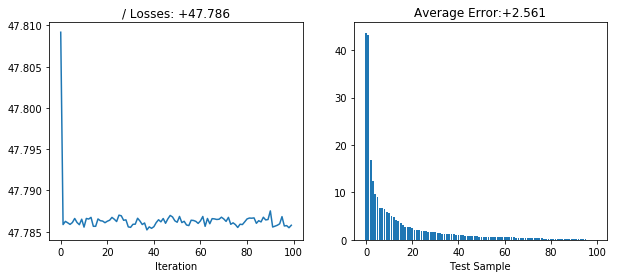

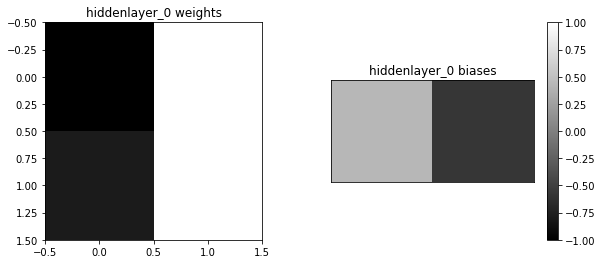

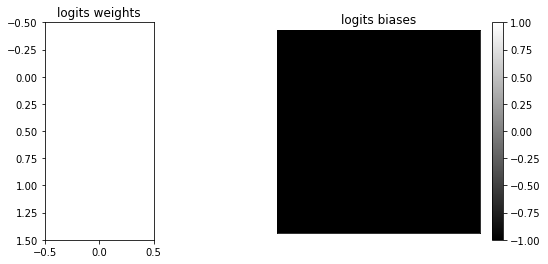

Sample Calculation for: /
Inputs (lo, hi): -0.224, -0.392                          -0.957, -0.021
Expected Output: +0.572                                  +45.246

Layer hiddenlayer_0
[[-1.197  1.589]
 [-0.789  1.477]]
[ 0.434 -0.572]
  Post Weights: +0.578, -0.935                          +1.162, -1.551
  Post  Biases: +1.012, -1.508                          +1.596, -2.124
  Post    ReLu: +1.012, +0.000                          +1.596, +0.000

Layer logits
[[1.751]
 [2.059]]
[-1.209]
  Post Weights: +1.771                                  +2.794
  Post  Biases: +0.562                                  +1.585

Elapse Time: 0.1766 hours


In [7]:
for op in generator():
    op = train(op, [2], 100, 900, 100, 1000, epsilon=0.0005)

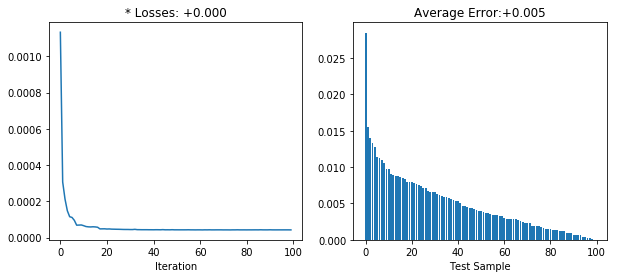

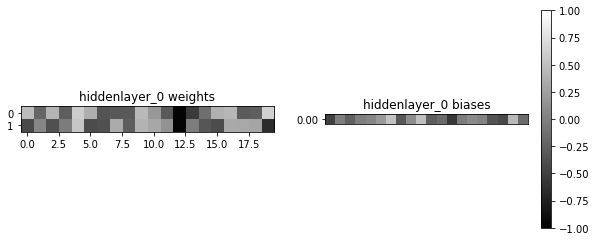

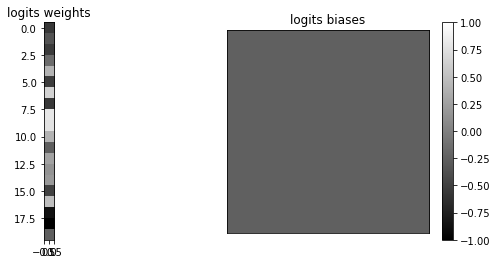

Sample Calculation for: *
Inputs (lo, hi): +0.122, -0.398                          -0.925, -0.980
Expected Output: -0.048                                  +0.906

Layer hiddenlayer_0
[[ 0.469 -0.209  0.403 -0.26   0.595  0.361 -0.343 -0.305 -0.294  0.448
   0.188 -0.302 -0.969 -0.545 -0.127  0.39   0.432 -0.281 -0.26   0.626]
 [-0.425  0.053 -0.37  -0.027  0.55  -0.399 -0.37   0.342 -0.263  0.406
   0.312  0.144 -0.954 -0.023 -0.323 -0.4    0.322  0.32   0.293 -0.647]]
[-0.49  -0.007 -0.243 -0.006  0.061  0.206  0.518 -0.31   0.109  0.497
 -0.26  -0.163 -0.569 -0.024  0.092  0.03  -0.341 -0.421  0.45  -0.163]
  Post Weights: +0.226, -0.046, +0.196, -0.021, -0.146, +0.202, +0.105, -0.173, +0.069, -0.107, -0.101, -0.094, +0.261, -0.057, +0.113, +0.206, -0.075, -0.161, -0.148, +0.333-0.017, +0.142, -0.010, +0.267, -1.089, +0.057, +0.680, -0.053, +0.529, -0.812, -0.479, +0.138, +1.831, +0.527, +0.434, +0.031, -0.716, -0.053, -0.046, +0.055
  Post  Biases: -0.264, -0.053, -0.047, -0.027, -0

In [9]:
op = train('*', [20], 100, 900, 100, 1000, epsilon=0.0005)

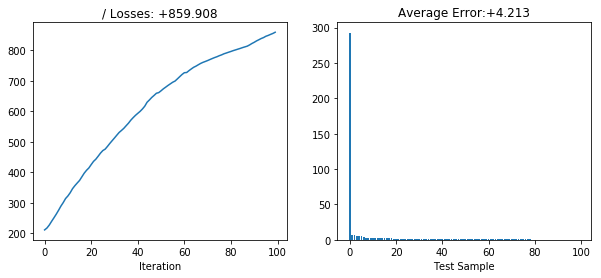

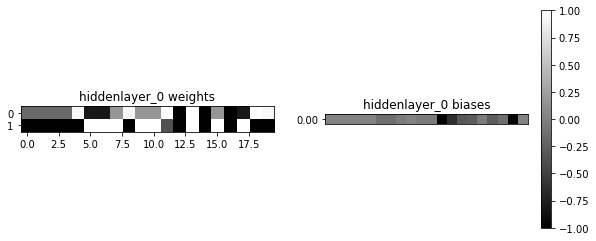

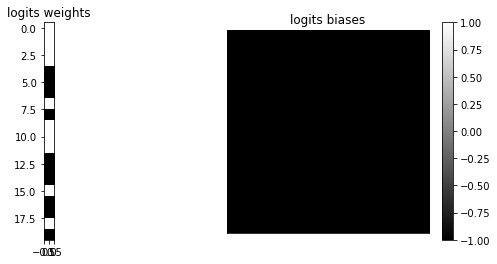

Sample Calculation for: /
Inputs (lo, hi): +0.925, +0.163                          +0.959, +0.007
Expected Output: +5.690                                  +135.727

Layer hiddenlayer_0
[[ -0.17   -0.173  -0.17   -0.171   0.934  -0.809  -0.814   0.169   0.925
    0.168   0.17    1.475  -1.403   2.655  -1.06    0.168  -1.072  -0.82
    1.201   0.938]
 [-49.945 -50.853 -50.007 -50.6   -45.559  47.994  48.34   49.92  -45.237
   49.423  49.983  -0.373 -32.412  53.781 -38.65   49.495 -39.044  48.636
  -18.872 -45.717]]
[ 0.032  0.032  0.032  0.032  0.037 -0.136 -0.137 -0.032  0.037 -0.031
 -0.032 -1.136 -0.639 -0.322 -0.273 -0.031 -0.276 -0.137 -0.962  0.036]
  Post Weights: -8.273, -8.423, -8.284, -8.381, -6.540, +7.052, +7.103, +8.269, -6.496, +8.186, +8.279, +1.303, -6.564, +11.194, -7.261, +8.198, -7.336, +7.146, -1.956, -6.562-0.516, -0.525, -0.516, -0.522, +0.574, -0.436, -0.439, +0.515, +0.568, +0.510, +0.516, +1.411, -1.574, +2.926, -1.290, +0.511, -1.304, -0.442, +1.019, +0.576
  Po

In [10]:
op = train('/', [20], 100, 900, 100, 1000, epsilon=0.0005)

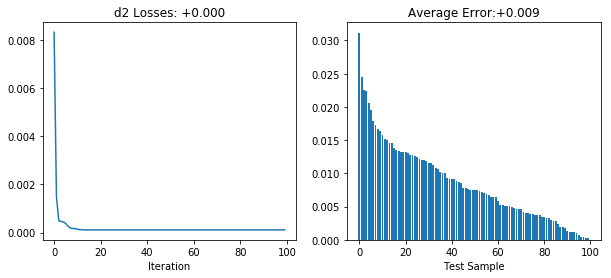

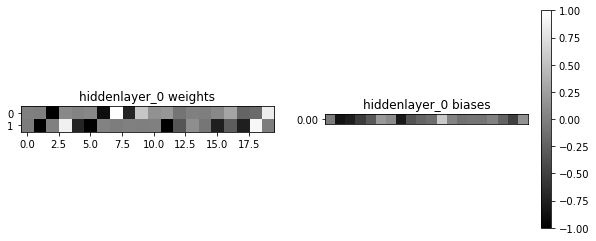

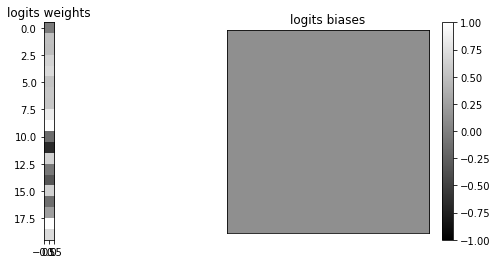

Sample Calculation for: d2
Inputs (lo, hi): -0.055, +0.930                          -0.154, +0.507
Expected Output: +0.867                                  +0.281

Layer hiddenlayer_0
[[ 0.003 -0.011 -1.021  0.078  0.035  0.06  -0.887  1.148 -0.706  0.554
   0.136  0.18  -0.089  0.002 -0.015  0.068  0.29  -0.211 -0.157  0.847]
 [-0.029 -1.174  0.007  0.88  -0.713 -0.986  0.017 -0.016  0.008 -0.006
   0.007 -1.098 -0.324  0.113 -0.073 -0.75  -0.271 -0.754  0.936 -0.016]]
[-0.036 -0.849 -0.761 -0.523 -0.299  0.197  0.089 -0.798 -0.338 -0.212
 -0.142  0.575  0.038 -0.114 -0.086 -0.089  0.009 -0.219 -0.499  0.137]
  Post Weights: -0.027, -1.090, +0.062, +0.814, -0.665, -0.920, +0.065, -0.078, +0.046, -0.036, -0.001, -1.030, -0.296, +0.105, -0.067, -0.701, -0.268, -0.689, +0.879, -0.061-0.015, -0.594, +0.161, +0.435, -0.367, -0.510, +0.145, -0.185, +0.113, -0.089, -0.017, -0.585, -0.151, +0.057, -0.035, -0.391, -0.182, -0.350, +0.499, -0.139
  Post  Biases: -0.064, -1.939, -0.699, +0.291, -

In [21]:
op = train('d2', [20], 100, 900, 100, 1000, epsilon=0.0005)

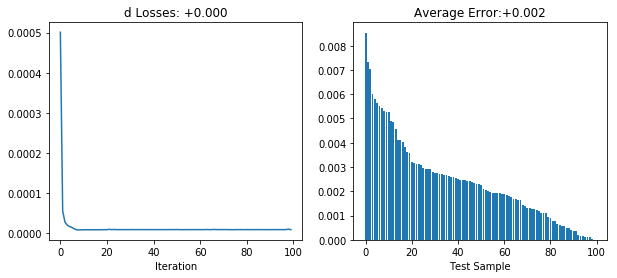

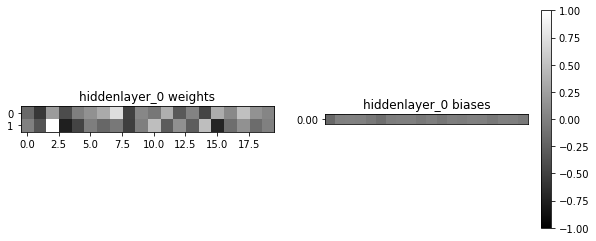

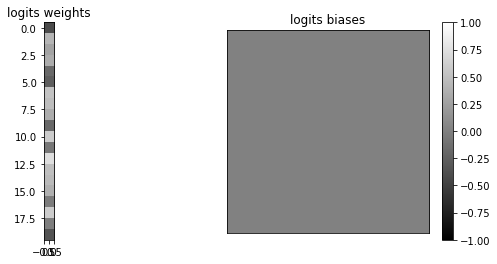

Sample Calculation for: d
Inputs (lo, hi): -0.107, +0.281                          +0.935, -0.898
Expected Output: +0.301                                  +1.296

Layer hiddenlayer_0
[[-0.173 -0.551  0.213 -0.405 -0.001  0.138  0.333  0.739 -0.482  0.062
  -0.065  0.372 -0.296  0.025 -0.458  0.349  0.071  0.503  0.143  0.044]
 [ 0.007 -0.34   1.078 -0.751 -0.465 -0.013 -0.192 -0.055 -0.504 -0.001
   0.486 -0.279  0.132 -0.267  0.485 -0.706 -0.139  0.139 -0.152  0.002]]
[-0.184  0.001  0.009  0.002 -0.058 -0.133 -0.022 -0.001 -0.001 -0.061
 -0.008 -0.076 -0.01  -0.028  0.    -0.002 -0.057  0.001 -0.    -0.045]
  Post Weights: +0.021, -0.037, +0.281, -0.168, -0.131, -0.018, -0.090, -0.095, -0.090, -0.007, +0.144, -0.118, +0.069, -0.078, +0.185, -0.236, -0.047, -0.015, -0.058, -0.004-0.168, -0.210, -0.769, +0.295, +0.416, +0.140, +0.483, +0.740, +0.002, +0.059, -0.496, +0.598, -0.395, +0.263, -0.863, +0.960, +0.191, +0.346, +0.270, +0.040
  Post  Biases: -0.164, -0.035, +0.289, -0.166, -0

In [22]:
op = train('d', [20], 100, 900, 100, 1000, epsilon=0.0005)

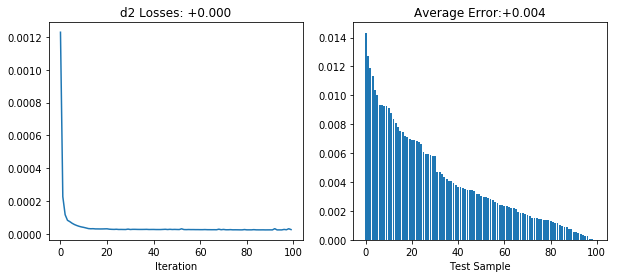

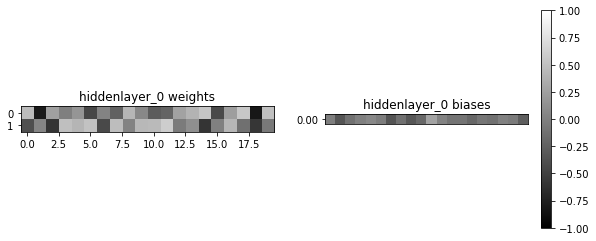

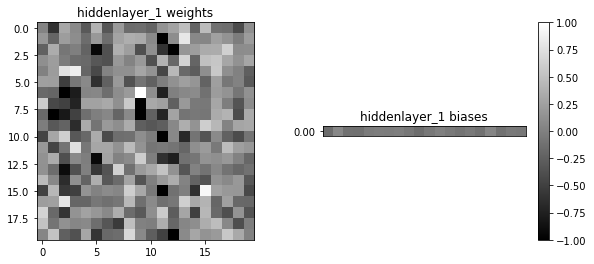

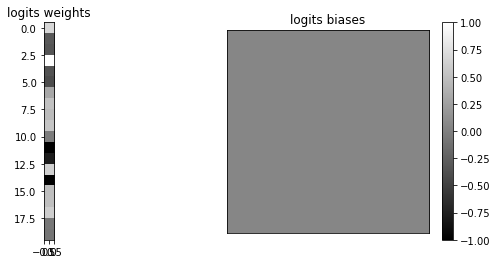

Sample Calculation for: d2
Inputs (lo, hi): +0.348, +0.468                          +0.491, +0.562
Expected Output: +0.340                                  +0.556

Layer hiddenlayer_0
[[ 0.464 -0.79   0.252 -0.005  0.171 -0.44   0.027 -0.227  0.429  0.067
  -0.276 -0.214  0.27   0.41   0.546 -0.42   0.239  0.559 -0.813  0.507]
 [-0.379  0.046 -0.589  0.492  0.418  0.517 -0.428  0.481  0.037  0.443
   0.454  0.606 -0.032  0.119 -0.584  0.002  0.428 -0.125 -0.572 -0.044]]
[-0.01  -0.328 -0.112  0.004  0.069 -0.017 -0.338 -0.121 -0.315 -0.183
  0.284  0.027 -0.09  -0.092 -0.188 -0.072 -0.111  0.015 -0.034 -0.265]
  Post Weights: -0.016, -0.254, -0.188, +0.228, +0.255, +0.089, -0.191, +0.146, +0.167, +0.231, +0.116, +0.209, +0.079, +0.198, -0.083, -0.145, +0.284, +0.136, -0.550, +0.156+0.015, -0.362, -0.207, +0.274, +0.319, +0.074, -0.227, +0.159, +0.231, +0.282, +0.120, +0.235, +0.115, +0.268, -0.060, -0.205, +0.358, +0.204, -0.720, +0.224
  Post  Biases: -0.026, -0.582, -0.300, +0.233, +

In [23]:
op = train('d2', [20, 20], 100, 900, 100, 1000, epsilon=0.0005)

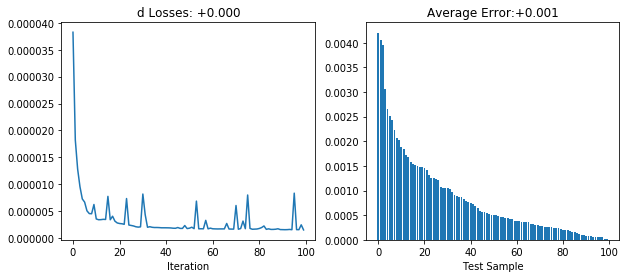

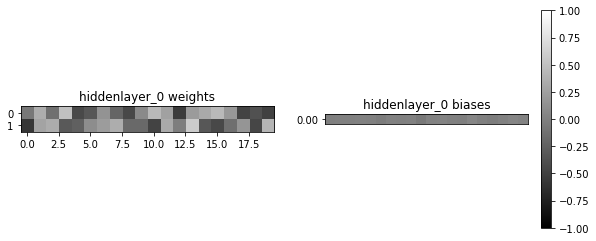

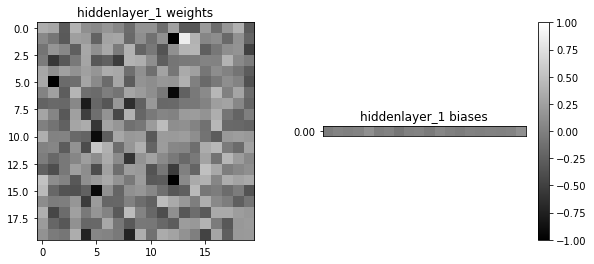

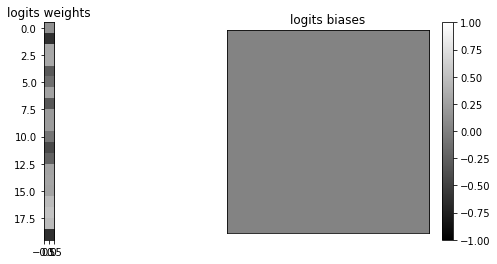

Sample Calculation for: d
Inputs (lo, hi): +0.179, +0.753                          -0.554, +0.934
Expected Output: +0.774                                  +1.086

Layer hiddenlayer_0
[[-0.058  0.352 -0.118  0.5   -0.42  -0.319  0.154 -0.21  -0.432  0.083
   0.451  0.26  -0.539  0.213  0.328  0.446  0.193 -0.47  -0.354 -0.489]
 [-0.574  0.279  0.351 -0.3   -0.243  0.107  0.22   0.359 -0.173 -0.177
  -0.469  0.335 -0.015  0.591 -0.317 -0.437 -0.128  0.17  -0.452  0.421]]
[-0.003  0.006  0.003  0.012  0.003 -0.029  0.008  0.001  0.011 -0.045
  0.018  0.026  0.004 -0.007  0.055  0.005 -0.021  0.013  0.041  0.021]
  Post Weights: -0.442, +0.273, +0.243, -0.136, -0.258, +0.024, +0.194, +0.232, -0.207, -0.119, -0.272, +0.299, -0.108, +0.483, -0.180, -0.249, -0.062, +0.044, -0.404, +0.229-0.504, +0.065, +0.393, -0.558, +0.006, +0.277, +0.120, +0.451, +0.078, -0.211, -0.688, +0.169, +0.285, +0.434, -0.478, -0.655, -0.226, +0.419, -0.226, +0.664
  Post  Biases: -0.445, +0.279, +0.246, -0.124, -0

In [24]:
op = train('d', [20, 20], 100, 900, 100, 1000, epsilon=0.0005)